# Sentiment analysis

## Data Understanding
"Small" subsets Data from 
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)
https://jmcauley.ucsd.edu/data/amazon_v2/index.html

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
asin - ID of the product, e.g. 0000013714
reviewerName - name of the reviewer
vote - helpful votes of the review
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
reviewText - text of the review
overall - rating of the product
summary - summary of the review
unixReviewTime - time of the review (unix time)
reviewTime - time of the review (raw)
image - images that users post after they have received the product

* Metadata

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table

In [1]:
# Data manipulation
import pandas as pd
#pd.set_option('max_columns', 200)
import numpy as np
#conda install pyarrow
import re

# Importing
import os
import gzip
import json
#conda install pyyaml
import yaml

# Data visualisation
import plotly.express as px
import plotly.graph_objects as go

#!conda install textstat
import textstat

config = yaml.safe_load(open('config.yml'))

# Output folder
out_dir = config['in_dir']
raw_dir = config['raw_dir']
# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    df = {}
    for i, d in enumerate(parse(path)):
        df[i] = d
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
# Meta data
# Filtering for laptops
product = 'laptop'

try:
  meta_df = pd.read_parquet(os.path.join(out_dir, product+'_meta_df.parquet'))
except:
  try:
    raw_meta_df = pd.read_parquet(os.path.join(raw_dir, 'raw_meta_df.parquet'))
  except:
    #5min to load
    raw_meta_df = getDF(r"data\raw\meta_Electronics.json.gz")
    print(raw_meta_df.info())
    display(raw_meta_df.head())
    raw_meta_df.loc[:, "category"] = raw_meta_df["category"].apply(lambda x: ' '.join(x))

  meta_df = raw_meta_df[['asin', 'category', 'main_cat', 'title', 'feature']]#.convert_dtypes()
  meta_df = meta_df.convert_dtypes()
  #meta_df = meta_df.astype({'category': 'string'}, errors='ignore')
  #meta_df.info()

  meta_df = meta_df[meta_df['category'].str.contains(product, case=False)]# & ~meta_df['category'].str.contains('accessories', case=False)]
  categories = meta_df['category'].value_counts().to_frame('Count').reset_index()
  meta_df = meta_df[meta_df['category'] == categories.iloc[0]['index']]
  # Export
  meta_df.to_parquet(os.path.join(out_dir, product+'_meta_df.parquet'))

asin_list = meta_df['asin'].unique()
asin_list

<StringArray>
['B00005LE4P', 'B00005NBJB', 'B00005O03C', 'B00005OBP1', 'B00005QERV',
 'B00005QJ2M', 'B00005QZ6E', 'B00005RI8S', 'B00005RI8R', 'B00005TP69',
 ...
 'B01HH26FWK', 'B01HH5ZM6M', 'B01HI9N408', 'B01HI9NT6M', 'B01HIJIZR0',
 'B01HIPPXBU', 'B01HIQBYQC', 'B01HIUFWXE', 'B01HIVMO3O', 'B01HJ8QRES']
Length: 10603, dtype: string

In [3]:
try:
  df = pd.read_parquet(os.path.join(out_dir, product+'_df.parquet'))
    
except:
  try:
    raw_df = pd.read_parquet(os.path.join(raw_dir, 'raw_df.parquet'))
  except:
    # 7min to load, 6739590 rows × 12 columns
    raw_df = getDF(r"data\raw\Electronics_5.json.gz")
    # Export
    raw_df.to_parquet(os.path.join(out_dir, 'raw_df.parquet'))

  # Filtering
  df = raw_df.query('asin in @asin_list')
  # Checking for missing values
  display(pd.DataFrame({'column_name': df.columns,
                        'percent_missing': round(df.isnull().sum() * 100 / len(df),0)})\
  .sort_values('percent_missing', ascending=False))

  # Removing unecessary columns, some due to too many missing values
  print(df.columns)

  df = df[['asin', 'overall', 'reviewText', 'summary', 'unixReviewTime']]
  # Alternative
  #df.drop(columns=['verified', 'reviewerID', 'style', 'reviewerName','unixReviewTime', 'vote', 'image'])

  # Check for duplicated values
  df = df.loc[~df.duplicated(subset=['reviewText', 'asin', 'unixReviewTime'])]

  # Keep only rows which has review text
  df = df.dropna(subset=['reviewText'])

  # Changing data types for memory usage efficiency
  #https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes

  # Max value of votes
  #print(product_df['vote'].dropna().astype('Int32', errors='ignore').max())

  df = df.astype({'asin': 'string',
                  'overall': 'category', #float16
                  'reviewText': 'string',
                  'summary': 'string',
                  #'vote': 'Sparse[int]', #'Int16',
                  #'verified': np.bool_,                          
                  }, errors='ignore')

  df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: pd.to_datetime(x, unit='s'))

  # To check improvement
  #product_df.memory_usage(index=False, deep=True)

  # Renaming columns for clarity
  df = df.rename(columns={'reviewText': 'text',
                          'unixReviewTime': 'date',
                          })\
      .reset_index(drop=True).copy()

  # Exporting
  df.to_parquet(os.path.join(out_dir, product+'_df.parquet'))
  

  print(f"Shape of the raw data: {raw_df.shape}\n")

  # Testing import
  #import_test = pd.read_parquet(os.path.join(out_dir, product+'_df.parquet'))
  #import_test

print(f"""Shape of the filtered df: {df.shape}\n
There are {len(df['asin'].unique())} unique products in the dataset\n
There are {len(df)} reviews""")

Shape of the filtered df: (51505, 5)

There are 2285 unique products in the dataset

There are 51505 reviews


## Feature understanding
Since reviews is the main variable being evaluated, how are they spread across the dataset?

In [4]:
summary_df = df['asin'].value_counts()
# Grouping thresholds
low_threshold = 5
high_threshold = 100
data = summary_df.values
data = np.where(data < low_threshold, low_threshold, data)
data = np.where(data > high_threshold, high_threshold, data)

fig = px.histogram(data, nbins=10, text_auto=True)
# Alternatively a boxplot
#fig = px.box(summary_df)

fig.update_layout(title = f"Histogram of amount of reviews per product", 
xaxis_title="Total number of reviews for a product",
yaxis_title="Number of products",
#font=dict(family="Verdana, monospace", size=14, color="Black"),
showlegend=False,
#legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
#legend_title="Category",
)

fig.show()
# The absolute majority of product have less than 50 reviews.

In [5]:
from plotly.subplots import make_subplots
# Grouping thresholds
low_threshold = 1
high_threshold = 100
bin_size = 10

fig = make_subplots(rows=1, cols=2, subplot_titles=('Full box plot', f'Detailed histogram of amount of reviews per product, with grouped outliers (> {high_threshold})'),
 horizontal_spacing=0.05,specs=[[{'type': 'bar'}]*2], column_widths=[0.4, 0.6])

summary_df = df['asin'].value_counts()
data = summary_df.values

fig.add_trace(go.Box(y=data, orientation='v', name='Products',), row=1, col=1)\
    .update_yaxes(title_text='Amount of reviews per product', row=1, col=1)
    #.update_xaxes(title_text='Quantity of products', row=1, col=1)\

# Histogram
#data = np.where(data < low_threshold, low_threshold, data)
data = np.where(data > high_threshold, high_threshold, data)
# bins = np.arange(0, high_threshold+2*bin_size, bin_size)
# counts, bins = np.histogram(data, bins=bins)
# fig.add_trace(go.Bar(x = counts, y=bins, orientation='h', text = counts, textposition='auto'), row=1, col=2)
fig.add_trace(go.Histogram(y=data, orientation='h', histnorm = 'percent'), row=1, col=2) #histnorm = 'percent
fig.update_xaxes(title_text='Percentage of quantity of products', row=1, col=2)
#fig.update_yaxes(title_text='Amount of reviews per product', row=1, col=2)

# Set the layout
fig.update_layout(
    title='Data Exploration',
    showlegend=False,
    #axis=dict(title='Quantity of products',),
    #height=400,
    #width=800,
)

fig.show()

In [7]:
# Create the bar plot
n = 20
joined = df.merge(meta_df, how='left', left_on='asin', right_on='asin')
grouped_df = joined.groupby('title').agg({'title': 'count', 'overall': 'mean'})
grouped_df = grouped_df.rename(columns={'title': 'Count', 'overall': 'Mean'})\
    .reset_index()\
    .sort_values('Count', ascending=False)[:n]

y = grouped_df['title']
y = [y[:40] + '...' if len(y) > 40 else y for y in y]
#x = x.values

# Define the color scale based on overall values
color_scale = 'balance' # 'RdBu'  # Red to Blue color scale

# Normalize the overall values between 0 and 1 for the color scale
normalized_overall = np.interp(grouped_df['Mean'], (np.min(grouped_df['Mean']), np.max(grouped_df['Mean'])), (0, 1))

# Create the bar plot
fig = go.Figure(data=go.Bar(
    y = y,
    x = grouped_df['Count'],
    orientation = 'h',
    text = grouped_df['Count'],  # Assign the values to the text attribute
    textposition = 'auto',  # Position the text inside the bars
    marker=dict(
        color=normalized_overall,  # Assign the overall values to the color attribute
        colorbar=dict(
            title='Mean score',  # Add a title to the colorbar
            tickmode='array',  # Set the tick mode to array
            nticks=5,  # Set the number of ticks on the colorbar
            tickvals=np.linspace(0, 1, 5),  # Specify the tick values
            ticktext=np.linspace(np.min(grouped_df['Mean']), np.max(grouped_df['Mean']), 5).round(1),  # Specify the tick labels
        ),
        colorscale=color_scale,  # Use the specified color scale
        reversescale=True  # Reverse the color scale
    ),
))

# Set the layout
fig.update_layout(
    title= f"Top {n} most reviewed products and their scores", 
    xaxis_title='Amount of reviews',
    #yaxis_title='Product',
    yaxis=dict(autorange="reversed"),
    plot_bgcolor='white',
    width=1200,  # Set the width of the plot
    height=700,  # Set the height of the plot
)

# Show the plot
fig.show()

## Text Analytics
Examples:
* Relashionships between features 
* Word frequency analysis,
* Sentence length analysis,
* Average word length analysis

In [28]:
# Define the function to count words
def count_words(string):
    words = string.split()
    return len(words)

# Count words
df['text_len'] = df['text'].apply(count_words)
# Readability
# df['text_standard']=df['text'].apply(lambda x: textstat.text_standard(x))
# df['dale_chall_score']=df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['gunning_fog']=df['text'].apply(lambda x: textstat.gunning_fog(x)) # School grade able to read, the lower, the easier
#df['flesh_reading_ease']=df['text'].apply(lambda x: textstat.flesch_reading_ease(x)) #0 - 100, 100 is easier
df['reading_time']=df['text'].apply(lambda x: textstat.reading_time(x))

# Count letters
#product_df['text_len'] = product_df['text'].str.len()

d:\Users\camil\anaconda3\envs\absa\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



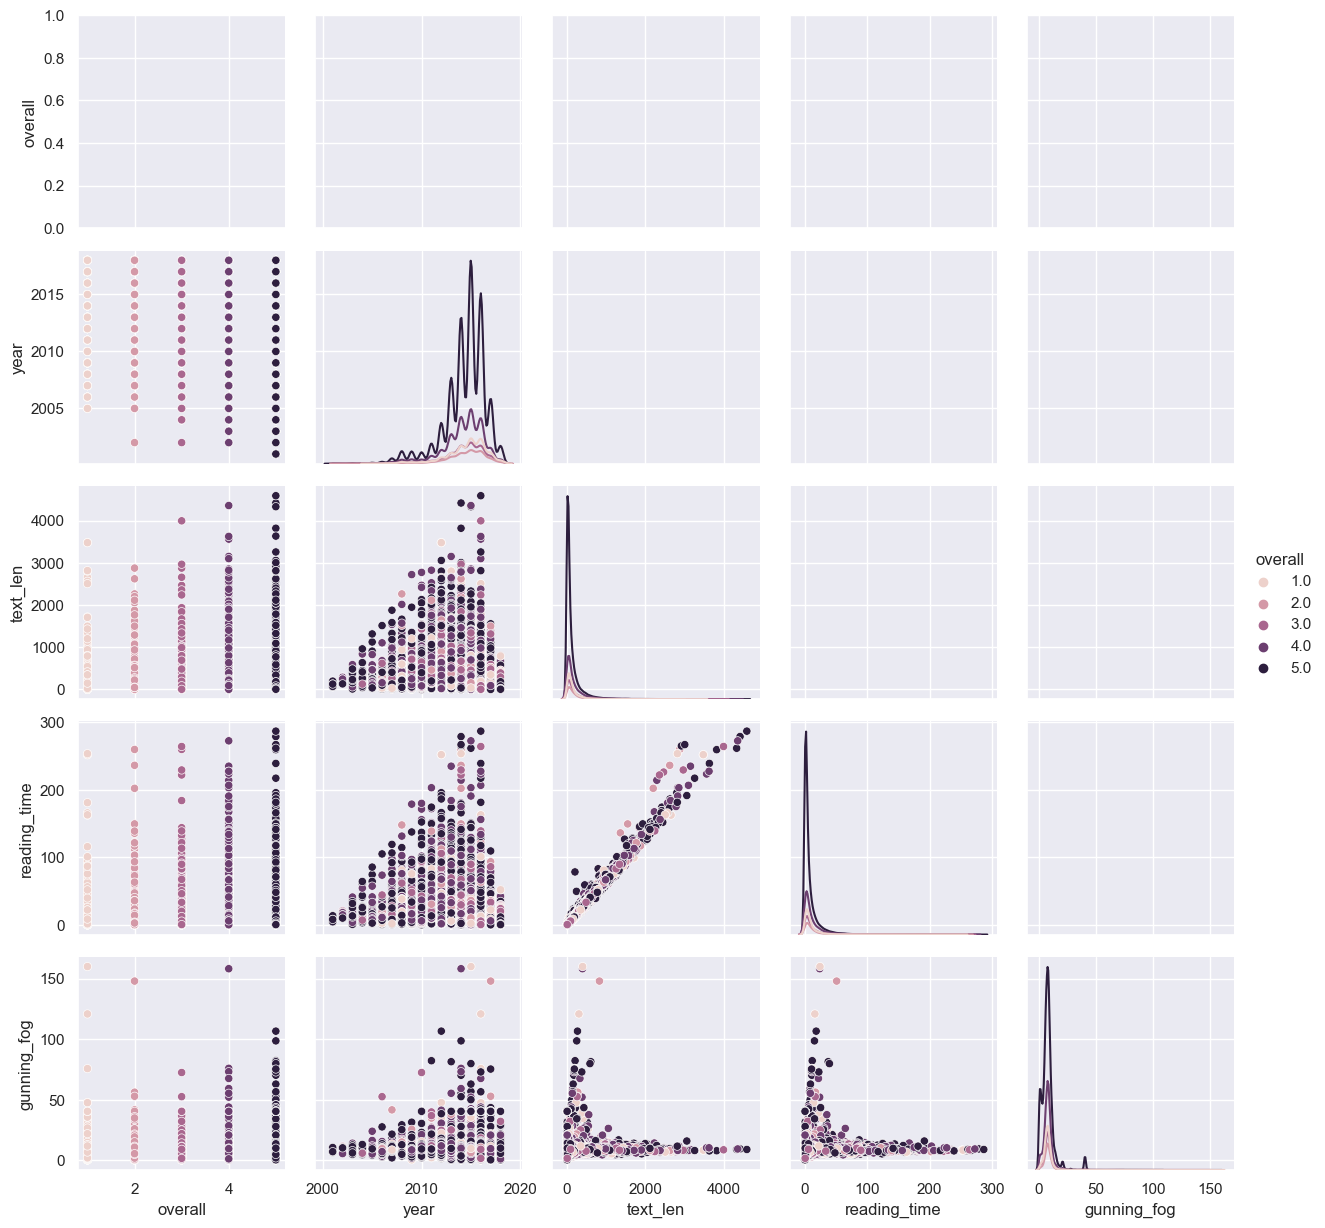

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
df = df.astype({'overall': 'float64'}, errors='ignore')
df.loc[:,"year"] = df["date"].apply(lambda x: x.year)

#ax = sns.pairplot(df, vars=['overall', 'date', 'text_len', 'reading_time', 'gunning_fog'], hue='overall')
ax = sns.PairGrid(df, vars=['overall', 'year', 'text_len', 'reading_time', 'gunning_fog'], hue='overall', diag_sharey=False)
ax.map_lower(sns.scatterplot)
ax.map_diag(sns.kdeplot)
ax.add_legend()

# Save the plot
plt.savefig("pairplot.png")